In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller , kpss
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [2]:
!wget https://raw.githubusercontent.com/aksaurabh/Stock-Price---Time-Series-Analysis-/main/SBIN.csv

--2024-08-22 12:52:18--  https://raw.githubusercontent.com/aksaurabh/Stock-Price---Time-Series-Analysis-/main/SBIN.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92586 (90K) [text/plain]
Saving to: ‘SBIN.csv’

SBIN.csv            100%[===================>]  90.42K  --.-KB/s    in 0.003s  

2024-08-22 12:52:18 (28.5 MB/s) - ‘SBIN.csv’ saved [92586/92586]



In [3]:
df = pd.read_csv('SBIN.csv', index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-19,292.000000,292.399994,286.000000,286.850006,269.995941,19831459
2019-08-20,287.299988,287.399994,280.649994,283.700012,267.031006,23204417
2019-08-21,285.500000,285.600006,276.299988,277.399994,261.101166,28226325
2019-08-22,278.299988,278.299988,267.299988,268.549988,252.771133,27728925
2019-08-23,267.100006,275.250000,262.700012,271.100006,255.171356,35212444


In [5]:
print("Summary Statistics")
df.describe()

Summary Statistics


,Open,High,Low,Close,Adj Close,Volume
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03
mean,465.728219,471.086883,459.647894,465.320486,449.042399,3.101152e+07
std,178.993887,180.130134,177.676121,178.925347,180.393224,2.589588e+07
min,151.949997,153.199997,149.449997,150.850006,141.986710,3.692065e+06
25%,319.150009,323.600006,315.199997,319.300003,300.539322,1.360796e+07
50%,485.000000,490.549988,478.649994,484.950012,462.216125,2.114284e+07
75%,578.050018,582.500000,573.350006,577.650024,564.484131,4.089773e+07
max,897.000000,912.000000,883.299988,905.650024,905.650024,2.149557e+08


The mean values for Open, High, Low, Close, and Adj Close are all around 269-273, indicating that the average price of the stock is around 269-273.

The standard deviation values for Open, High, Low, Close, and Adj Close are all around 178 - 180, indicating that the stock price is highly volatile.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1235 entries, 2019-08-19 to 2024-08-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1235 non-null   float64
 1   High       1235 non-null   float64
 2   Low        1235 non-null   float64
 3   Close      1235 non-null   float64
 4   Adj Close  1235 non-null   float64
 5   Volume     1235 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 67.5 KB


<Axes: >

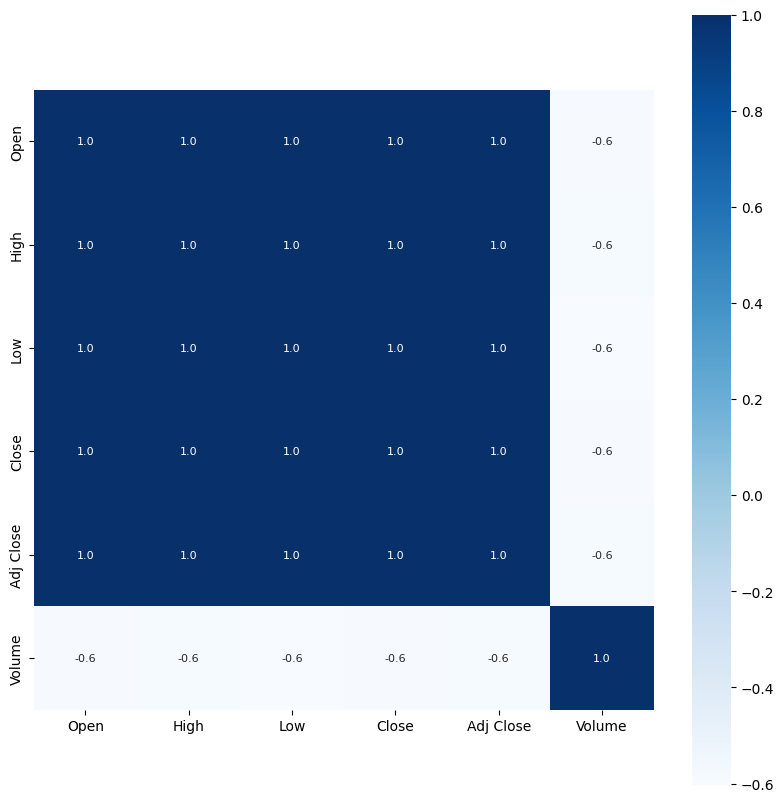

In [ ]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

There are no null values in the dataset

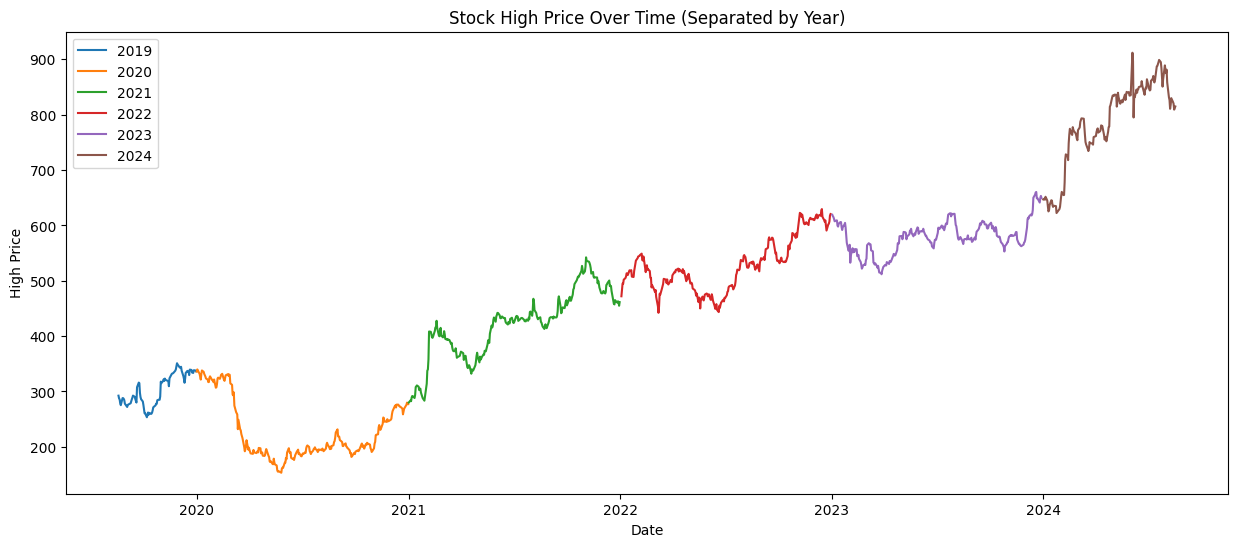

In [8]:
plt.figure(figsize=(15, 6))
for year, group in df.groupby('Year'):
    plt.plot(group.index, group['High'], label=year)

plt.title('Stock High Price Over Time (Separated by Year)')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.show()

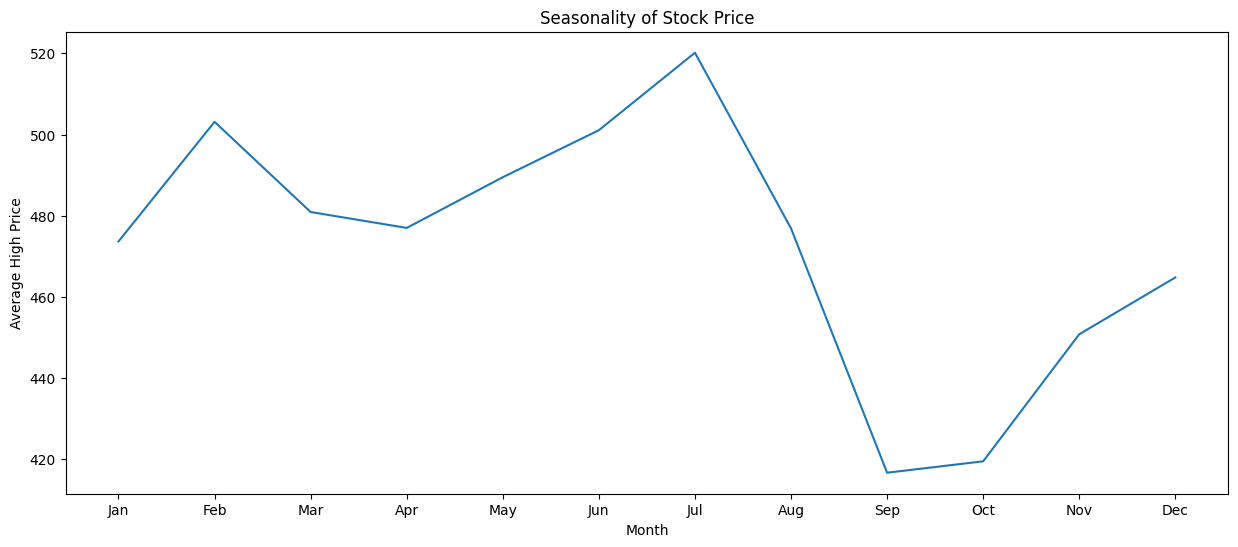

In [10]:
# Resample data to monthly frequency
monthly_high = df['High'].resample('M').mean()

plt.figure(figsize=(15, 6))
plt.plot(range(1, 13), monthly_high.groupby(monthly_high.index.month).mean())
plt.xlabel('Month')
plt.ylabel('Average High Price')
plt.title('Seasonality of Stock Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()




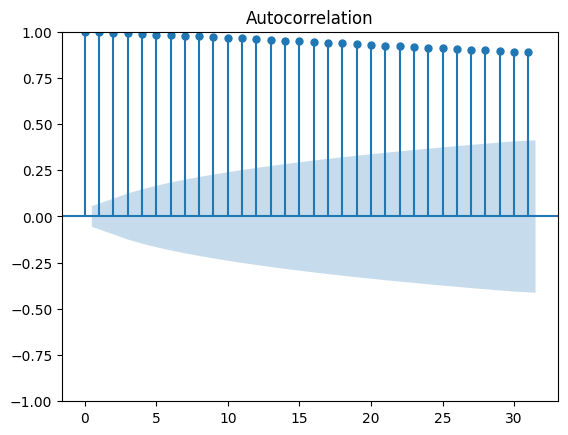

In [14]:
# prompt: plot acf for df high

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['High'])
plt.show()


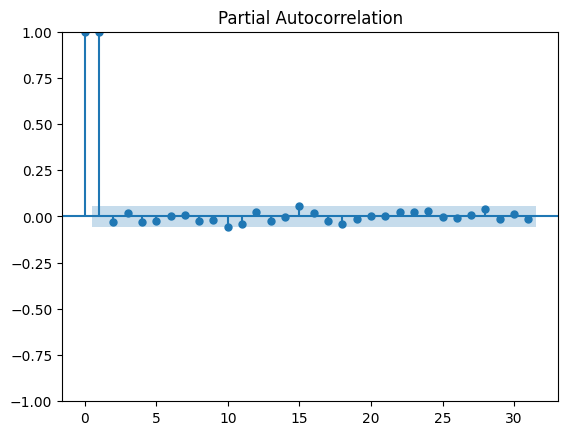

In [15]:
# prompt: plot pacf for df high

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['High'])
plt.show()


In [23]:
def check_stationarity(timeseries , title):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [26]:
print("Checking stationarity of the original series:")
check_stationarity(df['High'],"Original time series")

Checking stationarity of the original series:
ADF Statistic: -0.2261045403976837
p-value: 0.9353376474036621
Critical Values: {'1%': -3.4356819860439574, '5%': -2.863894574114006, '10%': -2.568023609111511}
Weak evidence against null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [27]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f"Total data points: {len(df)}")
print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Total data points: 1235
Training set size: 988
Testing set size: 247


In [28]:
# Check stationarity of the original series (training and testing)
check_stationarity(train['Close'], "training set (original series)")
check_stationarity(test['Close'], "testing set (original series)")

ADF Statistic: -0.6851433579417157
p-value: 0.8505603048288695
Critical Values: {'1%': -3.4369927443074353, '5%': -2.864472756705845, '10%': -2.568331546097238}
Weak evidence against null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
ADF Statistic: -1.0288628958914776
p-value: 0.7425922241670675
Critical Values: {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}
Weak evidence against null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [29]:
check_stationarity(train['High'].diff().dropna(), "training set (differenced series)")
check_stationarity(test['High'].diff().dropna(), "testing set (differenced series)")

ADF Statistic: -11.890455597510337
p-value: 5.885497827528018e-22
Critical Values: {'1%': -3.4370266558635914, '5%': -2.864487711945291, '10%': -2.5683395116993872}
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
ADF Statistic: -13.49073062758686
p-value: 3.1099870301881706e-25
Critical Values: {'1%': -3.457437824930831, '5%': -2.873459364726563, '10%': -2.573122099570008}
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


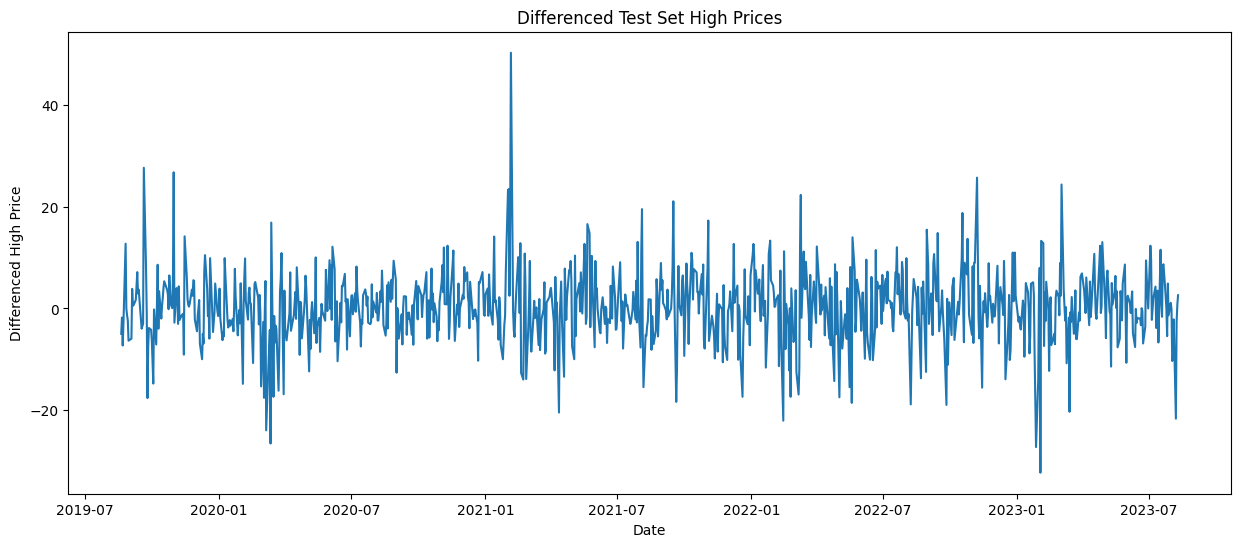

In [42]:
# prompt: plot test diff high

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(train['High'].diff().dropna())
plt.title('Differenced Test Set High Prices')
plt.xlabel('Date')
plt.ylabel('Differenced High Price')
plt.show()


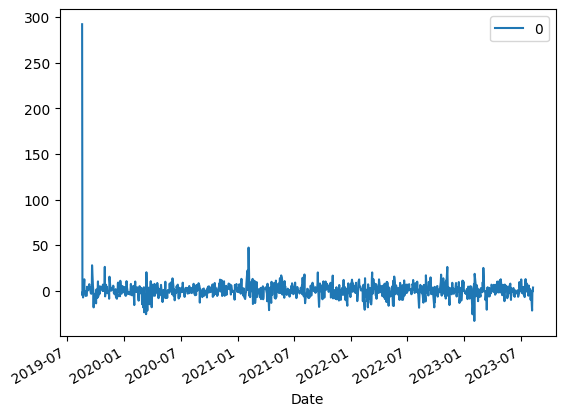

In [45]:
# Plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

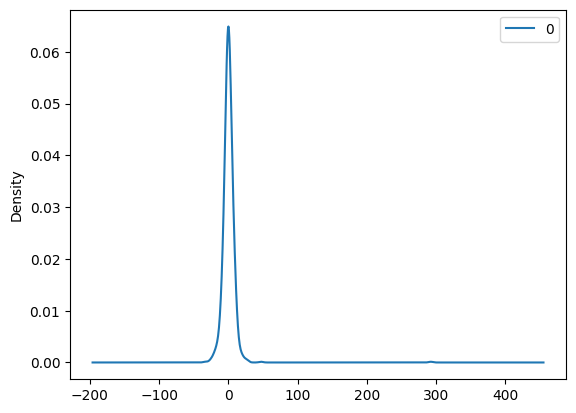

In [46]:
# Plot the density of residuals
residuals.plot(kind='kde')
plt.show()

In [47]:
# Print out the statistics of the residuals
print(residuals.describe())

                0
count  988.000000
mean     0.559323
std     11.589413
min    -33.208577
25%     -3.118875
50%      0.261818
75%      3.798665
max    292.399994


In [54]:
print("\
Analysis complete.")

Analysis complete.
